In [2]:
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
api = wandb.Api()
entity = "evangeorgerex"
project = "fwal"

In [4]:

def get_mnar_data(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    # Iterate through the run history to extract the desired metrics
    keys = [
        "fraction_missing_features",
        "mean_MNAR_imputation_test_metrics.F1_weighted", "missforest_MNAR_imputation_test_metrics.F1_weighted", 'ice_MNAR_imputation_test_metrics.F1_weighted'
        ]
    
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    history_dict['fraction_missing_features'] = np.unique(history_dict['fraction_missing_features'])

    return history_dict

def get_mcar_data(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    
            # 'fraction_missing_features_MCAR'+logging_key: fraction,
            # 'MCAR_imputation_valid_metrics'+logging_key: valid_metrics,
            # 'MCAR_imputation_test_metrics'+logging_key: test_metrics

    # Iterate through the run history to extract the desired metrics
    
    keys = [
        "fraction_missing_features",
        "mean_MCAR_imputation_test_metrics.F1_weighted", "missforest_MCAR_imputation_test_metrics.F1_weighted", 'ice_MCAR_imputation_test_metrics.F1_weighted'
        ]
    
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    history_dict['fraction_missing_features'] = np.unique(history_dict['fraction_missing_features'])
    return history_dict

def plot_mcar(mcar_data):
    '''
    Plots the test-time intervention F1 scores for MCAR and MNAR missing data
    '''
    # Create a pandas dataframe from the data
    mcar_df = pd.DataFrame(mcar_data)

    # Plot the data
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=mcar_df, x="fraction_missing_features", y="mean_MCAR_imputation_test_metrics.F1_weighted", label="MCAR")
    plt.xlabel("Fraction of missing features")
    plt.ylabel("F1 score")
    plt.title("F1 score for MCAR and MNAR missing data")
    plt.legend()
    plt.show()


In [5]:
def get_run_data(run):
    """
    Extracts both MCAR and MNAR data for a given run.
    """
    mcar_data = get_mcar_data(run)
    mnar_data = get_mnar_data(run)
    return mcar_data, mnar_data

def get_sweep_runs(api, entity, project, sweep_id):
    """
    Retrieves and processes all runs within a given sweep.
    """
    sweep_runs = api.sweep(f"{entity}/{project}/{sweep_id}").runs
    all_run_data = {}
    for run in sweep_runs:
        if run.state != "finished":
            continue
        run_id = run.id
        mcar_data, mnar_data = get_run_data(run)
        all_run_data[run_id] = {
            'mcar': mcar_data,
            'mnar': mnar_data,
            'dataset': run.config['dataset']  # assuming dataset info is stored in run configuration
        }
    return all_run_data

def aggregate_data_by_dataset(all_run_data):
    """
    Aggregates run data by dataset.
    """
    dataset_data = {}
    for run_id, data in all_run_data.items():
        dataset_name = data['dataset']
        if dataset_name not in dataset_data:
            dataset_data[dataset_name] = {'mcar': [], 'mnar': []}
        dataset_data[dataset_name]['mcar'].append(data['mcar'])
        dataset_data[dataset_name]['mnar'].append(data['mnar'])
    return dataset_data

def plot_dataset_mnar(dataset_data, dataset_name):
    """
    Plots MNAR data for a specific dataset.
    """
    data = pd.concat([pd.DataFrame(d) for d in dataset_data[dataset_name]['mnar']])
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x="fraction_missing_features", y="mean_MNAR_imputation_test_metrics.F1_weighted", label="Mean MNAR")
    sns.lineplot(data=data, x="fraction_missing_features", y="missforest_MNAR_imputation_test_metrics.F1_weighted", label="MissForest MNAR")
    sns.lineplot(data=data, x="fraction_missing_features", y="ice_MNAR_imputation_test_metrics.F1_weighted", label="ICE MNAR")
    plt.xlabel("Fraction of Missing Features")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Scores for MNAR Missing Data in Dataset: {dataset_name}")
    plt.legend()
    plt.show()

def plot_dataset_mcar(dataset_data, dataset_name):
    """
    Plots McAR data for a specific dataset.
    """
    data = pd.concat([pd.DataFrame(d) for d in dataset_data[dataset_name]['mcar']])
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x="fraction_missing_features", y="mean_MCAR_imputation_test_metrics.F1_weighted", label="Mean MCAR")
    sns.lineplot(data=data, x="fraction_missing_features", y="missforest_MCAR_imputation_test_metrics.F1_weighted", label="MissForest MCAR")
    sns.lineplot(data=data, x="fraction_missing_features", y="ice_MCAR_imputation_test_metrics.F1_weighted", label="ICE MCAR")
    plt.xlabel("Fraction of Missing Features")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Scores for MNAR Missing Data in Dataset: {dataset_name}")
    plt.legend()
    plt.show()


In [6]:

# Define line styles and colors
line_styles = {
    "mean": '-',        # solid line for mean
    "missforest": '--', # dashed line for MissForest
    "ice": ':',         # dotted line for ICE
}
# Using a more subdued color palette
colors = {
    "MLP": "#377eb8",    # blue
    "xgboost": "#4daf4a", # green
    "F-Act": "#ff7f00", # orange
    "lasso": "#984ea3", # purple
    # Add more models/colors as necessary
}

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def get_mnar_data(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    # Iterate through the run history to extract the desired metrics
    keys = [
        "fraction_missing_features",
        "mean_MNAR_imputation_test_metrics.F1_weighted", "missforest_MNAR_imputation_test_metrics.F1_weighted", 'ice_MNAR_imputation_test_metrics.F1_weighted'
        ]
    
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    history_dict['fraction_missing_features'] = np.unique(history_dict['fraction_missing_features'])

    return history_dict

def get_mcar_data(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    
            # 'fraction_missing_features_MCAR'+logging_key: fraction,
            # 'MCAR_imputation_valid_metrics'+logging_key: valid_metrics,
            # 'MCAR_imputation_test_metrics'+logging_key: test_metrics

    # Iterate through the run history to extract the desired metrics
    
    keys = [
        "fraction_missing_features",
        "mean_MCAR_imputation_test_metrics.F1_weighted", "missforest_MCAR_imputation_test_metrics.F1_weighted", 'ice_MCAR_imputation_test_metrics.F1_weighted'
        ]
    
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    history_dict['fraction_missing_features'] = np.unique(history_dict['fraction_missing_features'])
    return history_dict


def get_run_data(run):
    """
    Extracts both MCAR and MNAR data for a given run.
    """
    mcar_data = get_mcar_data(run)
    mnar_data = get_mnar_data(run)
    return mcar_data, mnar_data

def get_all_sweeps(api, entity, project, sweep_ids):
    """
    Retrieves and processes all runs across multiple sweeps.
    """
    all_run_data = {}
    for sweep_id in sweep_ids:
        sweep_runs = api.sweep(f"{entity}/{project}/{sweep_id}").runs
        for run in sweep_runs:
            if run.state != "finished":
                continue
            run_id = run.id
            mcar_data, mnar_data = get_run_data(run)
            model = run.config['model']  # extracting model name from the run configuration
            dataset = run.config['dataset']
            all_run_data[run_id] = {
                'mcar': mcar_data,
                'mnar': mnar_data,
                'model': model,
                'dataset': dataset
            }
    return all_run_data

def aggregate_data_by_dataset_and_model(all_run_data):
    """
    Aggregates run data by dataset and model.
    """
    aggregated_data = {}
    for run_id, data in all_run_data.items():
        dataset_name = data['dataset']
        model_name = data['model']
        if model_name == 'fwal':
            model_name = 'MLP'
        key = (dataset_name, model_name)
        if key not in aggregated_data:
            aggregated_data[key] = {'mcar': [], 'mnar': []}
        aggregated_data[key]['mcar'].append(data['mcar'])
        aggregated_data[key]['mnar'].append(data['mnar'])
    return aggregated_data



def plot_mcar_by_dataset(aggregated_data, dataset_name):
    """
    Plots MCAR data for all models for a specified dataset with aesthetic customizations.
    """
    plt.figure(figsize=(12, 8))
    for (dataset, model_name), data in aggregated_data.items():
        if dataset == dataset_name and data['mcar']:
            df = pd.concat([pd.DataFrame(d) for d in data['mcar'] if d])
            if not df.empty:
                for method in ['mean', 'missforest', 'ice']:
                    column_name = f"{method}_MCAR_imputation_test_metrics.F1_weighted"
                    if column_name in df.columns:
                        sns.lineplot(
                            data=df, x="fraction_missing_features", y=column_name,
                            label=f"{method.capitalize()} {model_name} MCAR",
                            linestyle=line_styles[method], color=colors.get(model_name, "#e41a1c") # default color if model not listed
                        )
    
    plt.xlabel("Fraction of Missing Features")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Scores for MCAR Missing Data in Dataset: {dataset_name}")
    plt.legend()
    plt.show()

def plot_mnar_by_dataset(aggregated_data, dataset_name):
    """
    Plots MNAR data for all models for a specified dataset with aesthetic customizations.
    """
    plt.figure(figsize=(12, 8))
    for (dataset, model_name), data in aggregated_data.items():
        if dataset == dataset_name and data['mnar']:
            df = pd.concat([pd.DataFrame(d) for d in data['mnar'] if d])
            if not df.empty:
                for method in ['mean', 'missforest', 'ice']:
                    column_name = f"{method}_MNAR_imputation_test_metrics.F1_weighted"
                    if column_name in df.columns:
                        sns.lineplot(
                            data=df, x="fraction_missing_features", y=column_name,
                            label=f"{method.capitalize()} {model_name} MNAR",
                            linestyle=line_styles[method], color=colors.get(model_name, "#e41a1c") # default color if model not listed
                        )
    
    plt.xlabel("Fraction of Missing Features")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Scores for MNAR Missing Data in Dataset: {dataset_name}")
    plt.legend()
    plt.show()


In [8]:

sweep_ids = [
    '7mg4b4vk', # XGB
    'wxtztkxy', # MLP
    'agf9pb9t',  # LASSO
    '5jj6p7p2', # SEFS
    'a53eo18d', # RF
    '9ttafcmg', # cae
    'ges23c7b', # supervised cae
    
    # PBMC:
    'q83zw5zr', # cae
    'xo580jlh', # lasso
    'j34lcodq', # mlp
    'wcuzo4zk', # rf
    'uxocsplc', # sefs
    '9jkgndfx', # supervised cae
    's0u0odhw', # xgb
    
    # finance:
    'n58j3sqb', # cae
    'xprjnu4r', # lasso
    'ayygv27o', # mlp
    'btv109nn', # rf
    '6ykxmxqn', # sefs
    '69b6ovbr', # supervised cae
    'k7jqc1q8', # xgb
    
    # COIL20:
    '0e94xqes', # lasso
    'oqtm21r6', # mlp
    'zcm4lu47', # rf
    'wmg1bb7b', # sefs
    'vtvt1ccr', # xgb
    ]  # Add your sweep IDs
all_run_data = get_all_sweeps(api, entity, project, sweep_ids)
aggregated_data = aggregate_data_by_dataset_and_model(all_run_data)


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


In [9]:
def aggregated_data_to_df(aggregated_data):
    data = aggregated_data
    columns = ['dataset', 'method', 'model', 'imputation', 'base_model', 'F1', 'missing_perc']
    df_rows = []

    # Process each dataset and method/model combination
    for (dataset, model), methods in data.items():
        for method, entries in methods.items():
            for entry in entries:
                missing_percs = entry['fraction_missing_features']
                for model_key, f1_scores in entry.items():
                    if model_key == 'fraction_missing_features':
                        continue
                    # Extract the model name and cleanup
                    imputation = model_key.split('_')[0]  # Adjust based on actual key names
                    model_name = imputation + ' ' + model
                    for f1, missing_perc in zip(f1_scores, missing_percs):
                        df_rows.append([dataset, method, model_name, imputation, model, f1, missing_perc])

    # Create DataFrame
    df = pd.DataFrame(df_rows, columns=columns)
    df['missing_perc'] = df['missing_perc'].astype(float) * 100
    return df

In [10]:

def get_mnar_data_fact(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    
            # 'fraction_missing_features_MCAR'+logging_key: fraction,
            # 'MCAR_imputation_valid_metrics'+logging_key: valid_metrics,
            # 'MCAR_imputation_test_metrics'+logging_key: test_metrics

    # Iterate through the run history to extract the desired metrics
    keys = [
        "fraction_missing_features_MNAR",
        "feature_selection_valid_metrics.F1_weighted", "feature_selection_test_metrics.F1_weighted", 
        ]
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    return history_dict

def get_mcar_data_fact(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    
            # 'fraction_missing_features_MCAR'+logging_key: fraction,
            # 'MCAR_imputation_valid_metrics'+logging_key: valid_metrics,
            # 'MCAR_imputation_test_metrics'+logging_key: test_metrics

    # Iterate through the run history to extract the desired metrics
    keys = [
        "fraction_missing_features_MCAR",
        "MCAR_imputation_valid_metrics.F1_weighted", "MCAR_imputation_test_metrics.F1_weighted", 
        ]
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    return history_dict


def get_sweep_runs_fact(api, entity, project, sweep_ids):
    """
    Retrieves and processes all runs within a given sweep.
    """
    all_run_data = {}
    
    for sweep_id in sweep_ids:
        sweep_runs = api.sweep(f"{entity}/{project}/{sweep_id}").runs
        for run in sweep_runs:
            run_id = run.id
            mcar_data = get_mcar_data_fact(run) 
            mnar_data = get_mnar_data_fact(run)
            all_run_data[run_id] = {
                'mcar': mcar_data,
                'mnar': mnar_data,
                'dataset': run.config['dataset']  # assuming dataset info is stored in run configuration
            }
    return all_run_data

def extract_data(nested_dict):
    data = []

    for key, datasets in nested_dict.items():
        dataset_name = datasets.get('dataset')
        for method, details in datasets.items():
            if method in ['mcar', 'mnar']:
                # Extract the specific method's metrics
                f1_key = [k for k in details.keys() if 'metrics.F1' in k and 'valid' in k][0]
                missing_perc = details['fraction_missing_features_' + method.upper()]
                f1_scores = details[f1_key]

                for perc, f1 in zip(missing_perc, f1_scores):
                    data.append({
                        'dataset': dataset_name,
                        'method': method,
                        'model': 'F-Act',
                        'imputation': '',
                        'base_model': 'F-Act',
                        'F1': f1,
                        'missing_perc': float(perc) * 100
                    })

    return pd.DataFrame(data)




In [11]:
fact_sweep_ids = [
    '8a09w5x3', # almost everything 
    'd9jds50i', # completed missing mice protein, PBMC. Re-did failed finance, USPS
    'lqlpi6z0', # madelon 
]
fact_data = get_sweep_runs_fact(api, entity, project, fact_sweep_ids)

In [12]:
baselines_df = aggregated_data_to_df(aggregated_data)


In [13]:
fact_df = extract_data(fact_data)

In [14]:
df = pd.concat([baselines_df, fact_df])
df = df[df['dataset'] != 'poly_binarised_decimalised_synth']

In [15]:
'''
# def plot_f1_vs_missing_features(df, dataset_name, method):
#     """
#     Plots F1 score against the fraction of missing features from a DataFrame,
#     with specific line styles based on the model type.
    
#     Parameters:
#     - df (pd.DataFrame): DataFrame containing the data.
#     - dataset_name (str): Name of the dataset to filter on.
#     - method (str): Method to filter on.
    
#     The DataFrame is expected to contain the columns 'missing_perc', 'f1', and 'model'.
#     """
    
#     # Filter the DataFrame based on the dataset name and method
#     filtered_df = df[(df['dataset'] == dataset_name) & (df['method'] == method)]

#     # Define custom line styles
#     line_styles = {
#         "mean": "solid",
#         "missforest": "dashed",
#         "ice": "dotted"
#     }
    
    
#     # Base models to identify for consistent coloring
#     base_models = filtered_df['base_model'].unique()
#     color_palette = sns.color_palette("tab10", n_colors=len(base_models))
#     model_color = {base: color for base, color in zip(base_models, color_palette)}
    
#     unique_models = filtered_df['model'].unique()
#     style_map = {}
#     color_map = {}
#     for model in unique_models:
#         # Assign line style
#         style_map[model] = next((line_styles[key] for key in line_styles if key in model.lower()), 'solid')
#         # Assign color based on base model
#         color_map[model] = next((model_color[base] for base in base_models if base in model.lower()), 'grey')


#     # Create a line plot with custom line styles
#     plt.figure(figsize=(10, 6))
#     for model in unique_models:
#         subset = filtered_df[filtered_df['model'] == model]
#         sns.lineplot(data=subset, x='missing_perc', y='F1', label=model, linestyle=style_map[model], color=color_map[model],marker='o')
    
#     # Adding labels and title
#     plt.title(f'F1 Score vs. Missing Features for {dataset_name} using {method}')
#     plt.xlabel('Missing Features (%)')
#     plt.ylabel('F1 Score')
#     plt.grid(True)
#     plt.legend(title='Model')
    
#     # Show the plot
#     plt.show()
'''

'\n# def plot_f1_vs_missing_features(df, dataset_name, method):\n#     """\n#     Plots F1 score against the fraction of missing features from a DataFrame,\n#     with specific line styles based on the model type.\n    \n#     Parameters:\n#     - df (pd.DataFrame): DataFrame containing the data.\n#     - dataset_name (str): Name of the dataset to filter on.\n#     - method (str): Method to filter on.\n    \n#     The DataFrame is expected to contain the columns \'missing_perc\', \'f1\', and \'model\'.\n#     """\n    \n#     # Filter the DataFrame based on the dataset name and method\n#     filtered_df = df[(df[\'dataset\'] == dataset_name) & (df[\'method\'] == method)]\n\n#     # Define custom line styles\n#     line_styles = {\n#         "mean": "solid",\n#         "missforest": "dashed",\n#         "ice": "dotted"\n#     }\n    \n    \n#     # Base models to identify for consistent coloring\n#     base_models = filtered_df[\'base_model\'].unique()\n#     color_palette = sns.color_p

In [16]:
# plot_f1_vs_missing_features(df, dataset_name='USPS', method='mnar')

In [17]:
def plot_f1_vs_missing_features(df, dataset_name, method, ax, base_model_color, line_styles):
    """
    Plots F1 score against the fraction of missing features from a DataFrame,
    without creating a legend in each subplot. Specific line styles based on the model type are used.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - dataset_name (str): Name of the dataset to filter on.
    - method (str): Method to filter on.
    - ax (matplotlib.axes._subplots.AxesSubplot): Axes object to draw the plot on.
    - base_model_color (dict): Dictionary mapping base models to colors.
    - line_styles (dict): Dictionary mapping models to line styles.
    """
    # Filter the DataFrame based on the dataset name and method
    filtered_df = df[(df['dataset'] == dataset_name) & (df['method'] == method)]
    
    # Plot on the given axes object
    unique_models = filtered_df['model'].unique()
    for model in unique_models:
        subset = filtered_df[filtered_df['model'] == model]
        # Use base_model field to determine color
        base_model = subset['base_model'].iloc[0]  # Assuming each model has a consistent base_model
        sns.lineplot(data=subset, x='missing_perc', y='F1', label=model,
                     linestyle=line_styles.get(model, 'solid'), color=base_model_color[base_model], marker='o', ax=ax)
    
    # Set subplot title and labels
    ax.set_title(f'{dataset_name} - {method}')
    ax.set_xlabel('Missing Features (%)')
    ax.set_ylabel('F1 Score')
    ax.grid(True)

    # Explicitly disable the legend for this subplot
    ax.legend_.remove()

def plot_f1_vs_missing_features_all_datasets(df, method):

    # Extract unique base models and assign unique colors
    base_models = df['base_model'].unique()
    color_palette = sns.color_palette("tab10", n_colors=len(base_models))
    base_model_color = {base_model: color for base_model, color in zip(base_models, color_palette)}

    line_styles = {model: ('dashed' if 'missforest' in model.lower() else 'dotted' if 'ice' in model.lower() else 'solid') for model in df['model'].unique()}

    dataset_names = df['dataset'].unique()

    fig, axes = plt.subplots(1, len(dataset_names) + 1, figsize=(16, 5), gridspec_kw={'width_ratios': [1]*len(dataset_names) + [0.2]}, sharey=True)

    for ax, dataset in zip(axes[:-1], dataset_names):
        plot_f1_vs_missing_features(df, dataset, method, ax, base_model_color, line_styles)

    # Collect handles and labels for a centralized legend using the last subplot used for plotting
    handles, labels = axes[0].get_legend_handles_labels()  # Grab handles/labels from any plotted axis
    legend_ax = axes[-1]
    legend_ax.legend(handles, labels, title='Model', loc='center')
    legend_ax.axis('off')

    plt.tight_layout()
    plt.show()


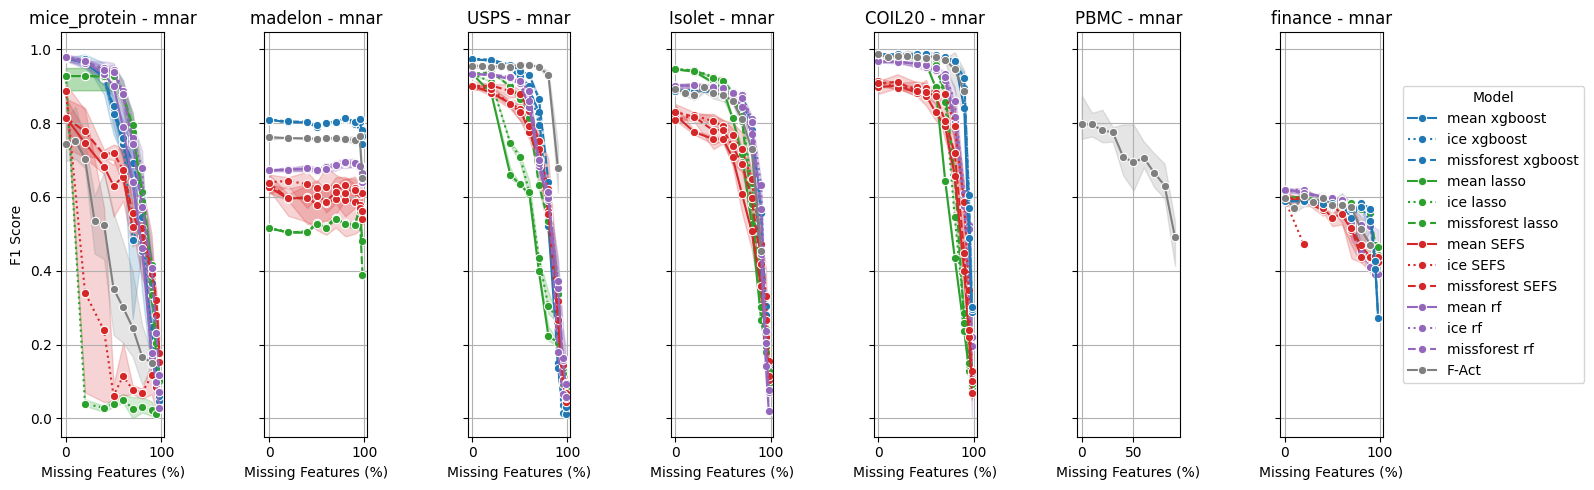

In [18]:
plot_f1_vs_missing_features_all_datasets(df, 'mnar')

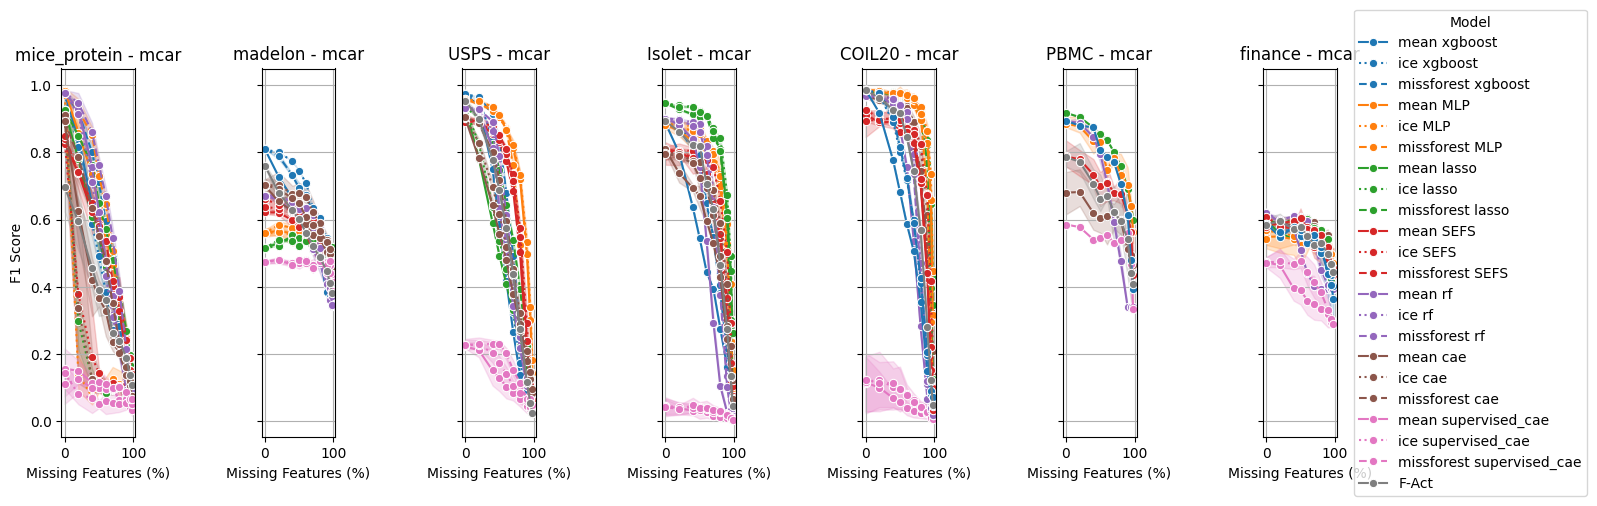

In [19]:
plot_f1_vs_missing_features_all_datasets(df, 'mcar')

In [20]:
df['base_model'].unique()

array(['xgboost', 'MLP', 'lasso', 'SEFS', 'rf', 'cae', 'supervised_cae',
       'F-Act'], dtype=object)

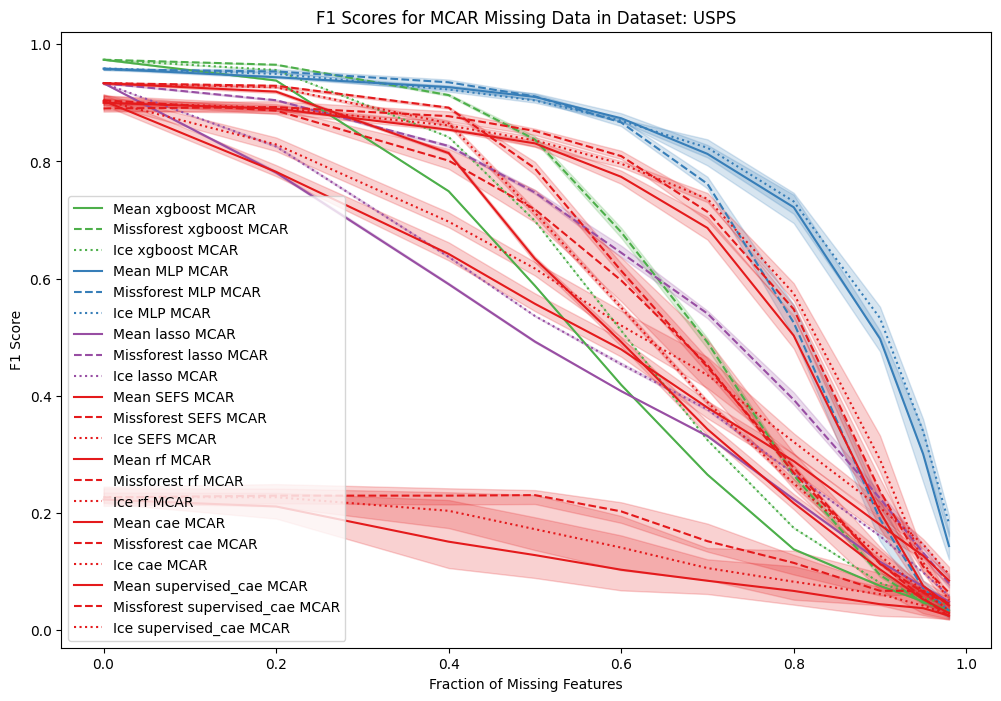

In [21]:
# Example usage after data aggregation:
dataset_name = 'USPS'  # Specify the dataset name to plot for
plot_mcar_by_dataset(aggregated_data, dataset_name)


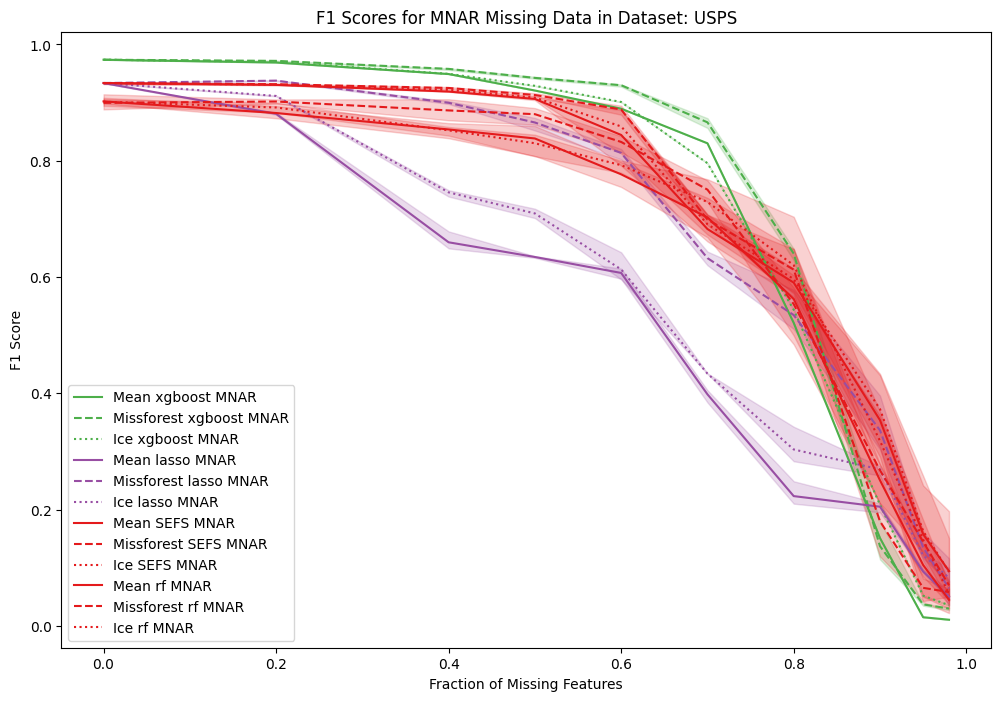

In [22]:

plot_mnar_by_dataset(aggregated_data, dataset_name)


In [23]:

def get_mnar_data_fact(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    # Iterate through the run history to extract the desired metrics
    keys = {
        "fraction_missing_features_MNAR": 'fraction_missing_features',
        "feature_selection_valid_metrics.F1_weighted": 'mean_MNAR_imputation_valid_metrics.F1_weighted', 
        "feature_selection_test_metrics.F1_weighted": 'mean_MNAR_imputation_test_metrics.F1_weighted', 
    }
    for row in run.scan_history():
        
        for key in keys:
            if key in row and row[key] is not None:
                if keys[key] not in history_dict:
                    history_dict[keys[key]] = []
                history_dict[keys[key]].append(row[key])
    return history_dict

def get_mcar_data_fact(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    # Iterate through the run history to extract the desired metrics
    keys = [
        "fraction_missing_features_MCAR",
        "MCAR_imputation_valid_metrics.F1_weighted", "MCAR_imputation_test_metrics.F1_weighted", 
        ]
    
    # Iterate through the run history to extract the desired metrics
    keys = {
        "fraction_missing_features_MCAR": 'fraction_missing_features',
        "MCAR_imputation_valid_metrics.F1_weighted": 'mean_MCAR_imputation_valid_metrics.F1_weighted', 
        "mean_MCAR_imputation_test_metrics.F1_weighted": 'mean_MCAR_imputation_test_metrics.F1_weighted', 
    }
    for row in run.scan_history():
        
        for key in keys:
            if key in row and row[key] is not None:
                if keys[key] not in history_dict:
                    history_dict[keys[key]] = []
                history_dict[keys[key]].append(row[key])
    return history_dict


def get_run_data_fact(run):
    """
    Extracts both MCAR and MNAR data for a given run.
    """
    mcar_data = get_mcar_data_fact(run)
    mnar_data = get_mnar_data_fact(run)
    return mcar_data, mnar_data


def get_data_from_runs_fact(api, entity, project, run_ids):
    all_run_data = {}
    for run_id in run_ids:
        run = api.run(f"{entity}/{project}/{run_id}")
        mcar_data, mnar_data = get_run_data_fact(run)
        
        all_run_data[run_id] = {
            'mcar': mcar_data,
            'mnar': mnar_data,
            'dataset': run.config['dataset']  # assuming dataset info is stored in run configuration
        }
    return all_run_data

def aggregate_data_by_dataset_fact(all_run_data):
    """
    Aggregates run data by dataset.
    """
    dataset_data = {}
    for run, data in all_run_data.items():
        dataset_name = data['dataset']
        key = (dataset_name, 'F-Act')
        if key not in dataset_data:
            dataset_data[key] = {'mcar': [], 'mnar': []}
        dataset_data[key]['mcar'].append(data['mcar'])
        dataset_data[key]['mnar'].append(data['mnar'])
    return dataset_data


In [24]:
def merge_aggregated_data(original_data, new_data):
    for key, data_entries in new_data.items():
        # if key in original_data:
        #     for entry in data_entries:
        #         original_data[key].append(entry)
        # else:
        original_data[key] = data_entries
    return original_data

def process_and_merge_run_data(api, entity, project, run_ids, existing_aggregated_data):
    run_data = get_data_from_runs_fact(api, entity, project, run_ids)
    new_aggregated_data = aggregate_data_by_dataset_fact(run_data)
    merged_data = merge_aggregated_data(existing_aggregated_data, new_aggregated_data)
    return merged_data

# Example usage
run_ids = [
    '5k4s8cmb', # USPS
    'ew98wxuq', # Isolet 0
    '42uzd7gp', # Isolet 1
    'ymqrmh6v', # Isolet 2
    '2e4w5nwo', # PBMC
    ] 
merged_aggregated_data = process_and_merge_run_data(api, entity, project, run_ids, aggregated_data)

# Now `merged_aggregated_data` includes data from the specified runs and can be used for further analysis or plotting.


KeyboardInterrupt: 

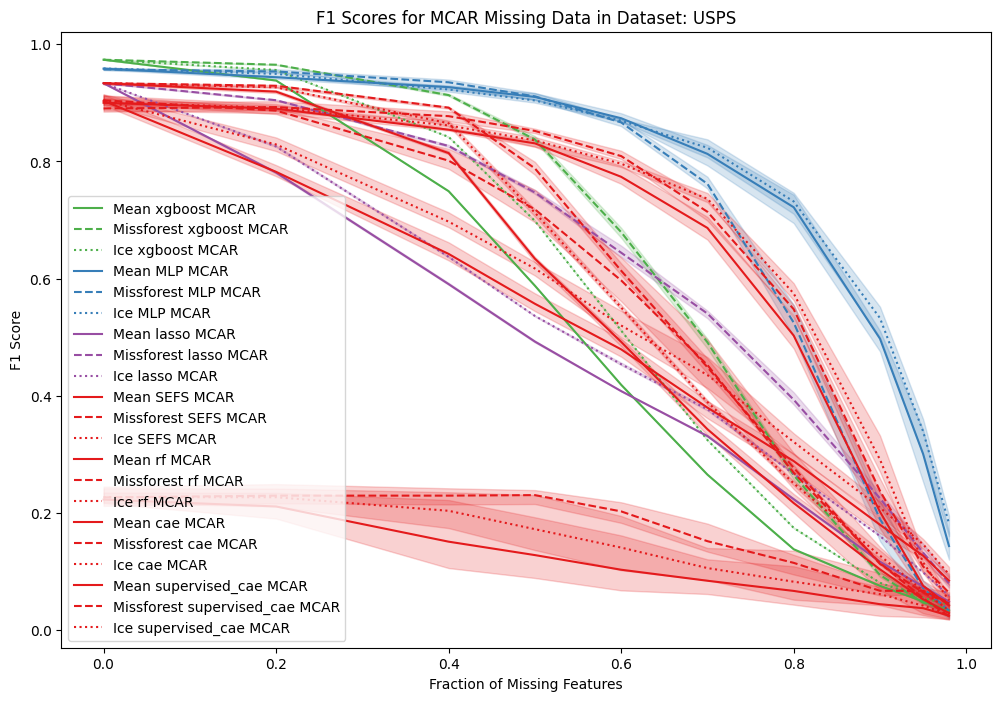

In [ ]:
# Example usage after data aggregation:
dataset_name = 'USPS'  # Specify the dataset name to plot for
plot_mcar_by_dataset(merged_aggregated_data, dataset_name)

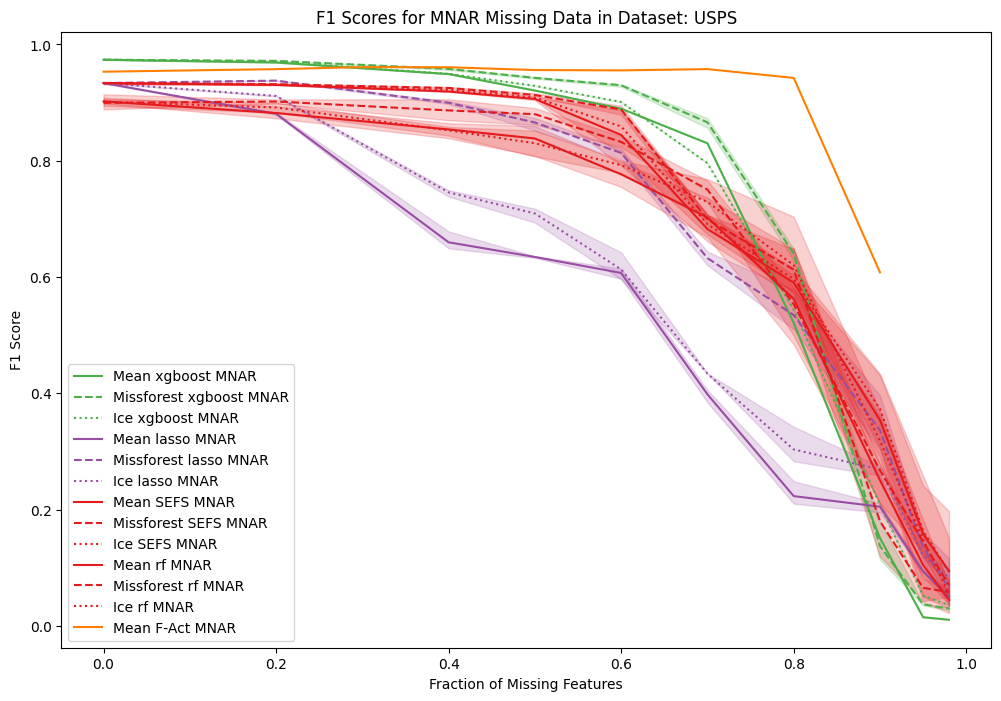

In [ ]:
plot_mnar_by_dataset(merged_aggregated_data, dataset_name)

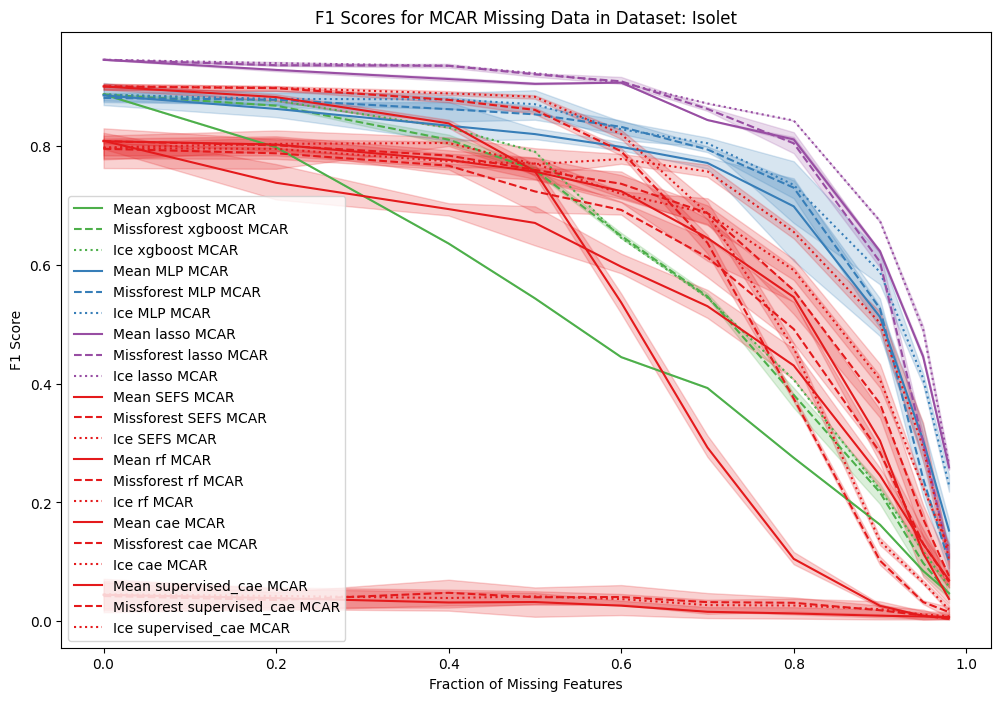

In [ ]:
# Example usage after data aggregation:
dataset_name = 'Isolet'  # Specify the dataset name to plot for
plot_mcar_by_dataset(merged_aggregated_data, dataset_name)

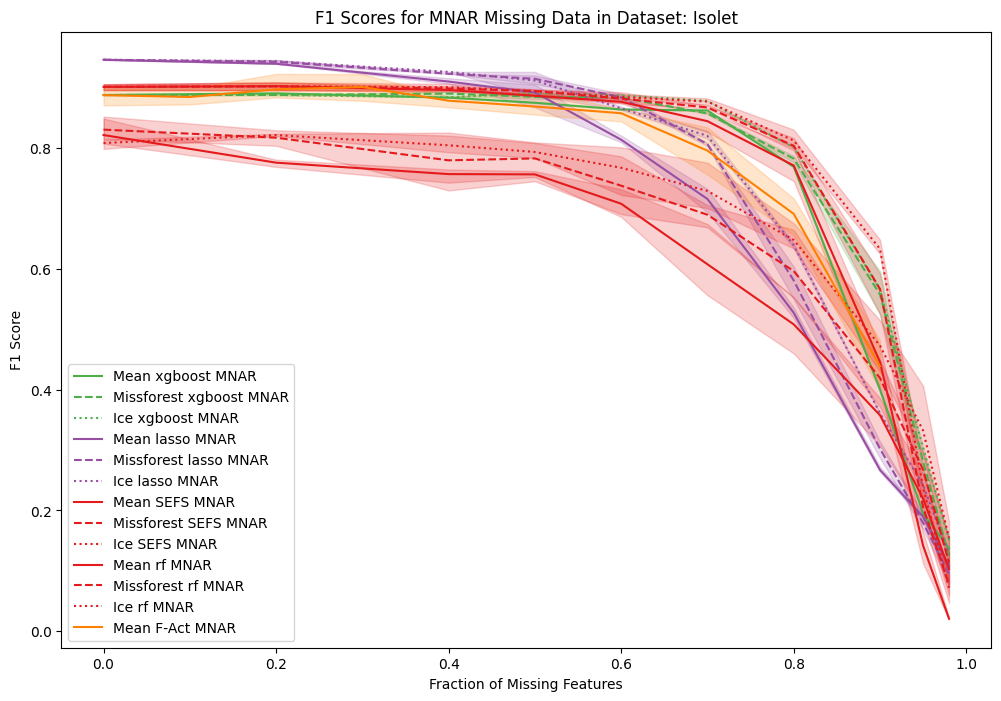

In [ ]:
# Example usage after data aggregation:
dataset_name = 'Isolet'  # Specify the dataset name to plot for
plot_mnar_by_dataset(merged_aggregated_data, dataset_name)